# Half cell data processing 
- This notebook processes the half cell data for the differential voltage analysi, including the following steps:
    1. Get SOC based on capacity 
    2. Interpolate the data to make electrode data to be of the same length 

In [1]:
import sys 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
current_dir = os.getcwd()
src_dir = os.path.join(current_dir, '..', 'src')
sys.path.append(src_dir)
from DVF_functions import *

In [3]:
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, '..')
df_pe_o = pd.read_csv(os.path.join(data_dir, 'data/dvf_data/XC_NMC532_C_20_0606_1_CD5.txt'), sep = '\t')
df_ne_o = pd.read_csv(os.path.join(data_dir, 'data/dvf_data/XC_AG_OCV_012424_2_CB8.txt'), sep = '\t')

### Visualize the cycling data 

cathode voltage3.2455738
anode voltage2.9867065


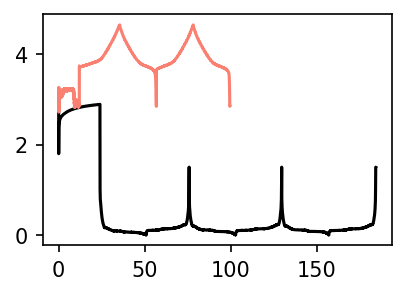

In [4]:
Gr_df = df_ne_o
NMC_df = df_pe_o
fig, axs = plt.subplots(dpi = 150, figsize = (3,2))
axs.plot(Gr_df['time/s']/3600, Gr_df['Ecell/V'], color = 'k')
axs.plot(NMC_df['time/s']/3600, NMC_df['Ecell/V'], color = 'salmon')
print('cathode voltage' + str(NMC_df['Ecell/V'].iloc[0]))
print('anode voltage' + str(Gr_df['Ecell/V'].iloc[0]))

In [5]:
def get_nmc_halfcell(Gr_df, filename, save):
    
    Gr_chosen = Gr_df[(Gr_df['cycle number'] == 1)&(Gr_df.Ns == 2)&(Gr_df['mode'] == 1)].copy()
    # plot it out to check 
#     plt.plot(Gr_chosen['Q charge/mA.h'], Gr_chosen['Ecell/V'])
    
    Gr_chosen['SOC_aligned'] = 100*Gr_chosen['Capacity/mA.h']/(Gr_chosen['Capacity/mA.h'].max())
    Gr_chosen = Gr_chosen.drop_duplicates(subset = 'SOC_aligned', keep = 'last')
    x = Gr_chosen['SOC_aligned']
    y = Gr_chosen['Ecell/V']
    f = interp1d(x, y, kind='cubic', fill_value="extrapolate")
    Gr_aligned = pd.DataFrame(index = np.arange(1001))
    z = np.arange(0, 100.1, 0.1)
    Gr_aligned['SOC_aligned'] = 100-z
    Gr_aligned['Voltage_aligned'] = f(z)
    # plt.plot(x, y)
    plt.plot(Gr_aligned['SOC_aligned'], Gr_aligned['Voltage_aligned'])
    # save the file 
    if save:
        Gr_aligned.to_csv(os.path.join(path, filename))
    return Gr_aligned

In [6]:
def get_gr_halfcell(Gr_df, filename, save):
    
    Gr_chosen = Gr_df[(Gr_df['cycle number'] == 1)&(Gr_df.Ns == 4)].copy()
    # plot it out to check 
#     plt.plot(Gr_chosen['Capacity/mA.h'], Gr_chosen['Ecell/V'])
    
    Gr_chosen['SOC_aligned'] = 100*(Gr_chosen['Capacity/mA.h']-Gr_chosen['Capacity/mA.h'].min())/(Gr_chosen['Capacity/mA.h'].max() - Gr_chosen['Capacity/mA.h'].min())
    Gr_chosen = Gr_chosen.drop_duplicates(subset = 'SOC_aligned', keep = 'last')
    x = Gr_chosen['SOC_aligned']
    y = Gr_chosen['Ecell/V']

    f = interp1d(x, y, kind='cubic', fill_value="extrapolate")
    Gr_aligned = pd.DataFrame(index = np.arange(1001))
    z = np.arange(0, 100.1, 0.1)
    Gr_aligned['SOC_aligned'] = 100-z
    Gr_aligned['Voltage_aligned'] = f(z)
    # plt.plot(x, y)
    plt.plot(Gr_aligned['SOC_aligned'], Gr_aligned['Voltage_aligned'])
#     plt.scatter(100-Gr_aligned['SOC_aligned'], Gr_aligned['Voltage_aligned'], s = 5)
#     save the file 
    if save:
        Gr_aligned.to_csv(os.path.join(path, filename))
    return Gr_aligned

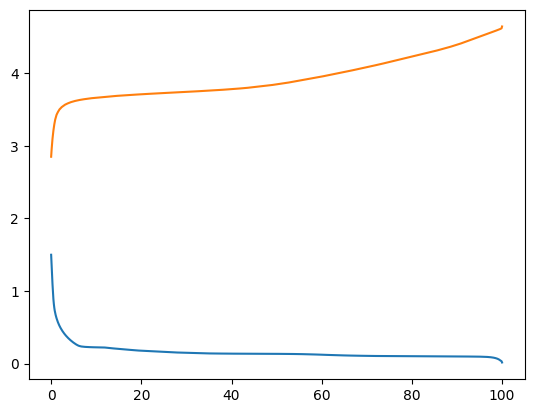

In [7]:
ne = get_gr_halfcell(df_ne_o, '', 0)
pe = get_nmc_halfcell(df_pe_o, '', 0)